# [Interval Competition: House Prices](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price)

## Описание
Как уже упоминалось, в регрессионном анализе нередко фокусируются на так называемых точечных прогнозах (отражающих центральную тенденцию). Однако в этом соревновании нас интересует создание интервала прогнозирования (отражающего дисперсию).

Наша задача — создать регрессионную модель с самыми узкими (наиболее «эффективными») общими интервалами прогнозирования

## Оценка
Мы оценим общую эффективность нашей модели, используя среднее значение показателя интервала Винклера, которое для отдельного интервала определяется следующим образом:

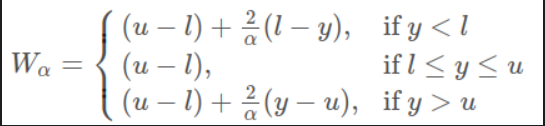

где 
 это истинная ценность, 
 это верхний предел прогнозного интервала, 
 это нижний предел прогнозного интервала, и 
 Это (100-процентное покрытие)/100.

Покрытие
В этом соревновании целью является номинальное предельное покрытие в 90% (т.е. 
). То есть 90% интервалов прогнозирования содержат истинное значение (y_true).

________________________________________________________________________________________________________________________________________________________

# Ипопрт необходимых библиотек

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone

## Data Engineering

## Удалим столбцы в которых есть пропущенные значения

In [95]:
def clearing_missing_values(df):
    print("Начало работы функции clearing_missing_values")
    kol_mistakes = df.isnull().sum()
    columns_with_mistakes = df.isnull().sum()[kol_mistakes > 0]
    drop_feature = columns_with_mistakes.index.tolist() + ["id"]
    df = df.drop(columns=drop_feature)
    return df


## Из числовых признаков формируем пары для выявления нелинейных зависимостей

In [96]:
def create_peirs_of_feature(df):
    print("Начало работы функции create_peirs_of_feature")

    from itertools import combinations

    important_nums = list(set([
        'area', 'sqft', 'land_val', 'imp_val', 'grade', 'beds',
        'bath_full', 'sqft_lot', 'sqft_1', 'sqft_fbsmt',
        'garb_sqft', 'gara_sqft'
    ]))
    
    

    for f1, f2 in combinations(important_nums, 2):
        col_name = f"{f1}_x_{f2}"
        df[col_name] = df[f1] * df[f2]

    return df

## Создадим данные связанные со временем, для выявления временных зависимостей

In [97]:
def add_date_features(df):
    print("Начало работы функции add_date_features")
    df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')

    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month

    df['month_sin'] = np.sin(2 * np.pi * df['sale_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['sale_month'] / 12)

    df['house_age'] = df['sale_year'] - df['year_built']

    df['renovated'] = (df['year_reno'] > 0).astype(int)

    df['years_since_renovation'] = np.where(
        df['year_reno'] > 0,
        df['sale_year'] - df['year_reno'],
        df['house_age']  
    )
    
    df.drop(columns=['sale_date'], inplace=True)

    return df

## Добавим еще различные полезные фичи

In [98]:
def new_features(df):
    print("Начало работы функции new_features")
    df['total_bath'] = df['bath_full'] + 0.75 * df['bath_3qtr'] + 0.5 * df['bath_half']
    df['total_view'] = df[[c for c in df.columns if 'view_' in c]].sum(axis=1)

    df['lot_utilization'] = df['sqft'] / df['sqft_lot']
    df['garage_ratio'] = df['gara_sqft'] / (df['sqft'] + 1e-3)
    df['bath_bed_ratio'] = df['total_bath'] / (df['beds'] + 1e-3)

    df['structure_share'] = df['imp_val'] / (df['imp_val'] + df['land_val'] + 1e-3)

    df['has_basement'] = (df['sqft_fbsmt'] > 0).astype(int)
    df['has_garage'] = (df['gara_sqft'] > 0).astype(int)
    df['was_renovated'] = (df['year_reno'] > 0).astype(int)
    df['has_view'] = (df['total_view'] > 0).astype(int)

    df['condition_grade'] = df['condition'] * df['grade']

    df['total_area'] = df['sqft'] + df['sqft_fbsmt'] + df['gara_sqft']

    df = df[df['total_area'] / (df['beds']+1e-3) > 300]

    return df


## Логарифмирование больших значений

In [99]:
def log_transform_features(df, flag_train = False):
    print("Начало работы функции log_transform_features")
    if flag_train:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'sale_price', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]
    else:
        log_candidates = [
            'grade_x_land_val', 'grade_x_sqft_lot', 'grade_x_sqft', 'grade_x_sqft_fbsmt', 'grade_x_gara_sqft',
            'grade_x_imp_val', 'beds_x_land_val', 'beds_x_sqft_lot', 'beds_x_sqft', 'beds_x_sqft_fbsmt',
            'beds_x_gara_sqft', 'beds_x_imp_val', 'garb_sqft_x_land_val', 'garb_sqft_x_sqft_lot',
            'garb_sqft_x_sqft', 'garb_sqft_x_sqft_fbsmt', 'garb_sqft_x_gara_sqft', 'garb_sqft_x_imp_val',
            'sqft_1_x_land_val', 'sqft_1_x_sqft_lot', 'sqft_1_x_sqft', 'sqft_1_x_sqft_fbsmt', 'sqft_1_x_gara_sqft',
            'sqft_1_x_imp_val', 'area_x_land_val', 'area_x_sqft_lot', 'area_x_sqft', 'area_x_sqft_fbsmt',
            'area_x_gara_sqft', 'area_x_imp_val', 'land_val_x_sqft_lot', 'land_val_x_sqft',
            'land_val_x_sqft_fbsmt', 'land_val_x_gara_sqft', 'land_val_x_imp_val', 'sqft_lot_x_sqft',
            'sqft_lot_x_sqft_fbsmt', 'sqft_lot_x_gara_sqft', 'sqft_lot_x_imp_val', 'bath_full_x_sqft',
            'bath_full_x_sqft_fbsmt', 'bath_full_x_gara_sqft', 'bath_full_x_imp_val', 'sqft_x_sqft_fbsmt',
            'sqft_x_gara_sqft', 'sqft_x_imp_val', 'sqft_fbsmt_x_gara_sqft', 'sqft_fbsmt_x_imp_val',
            'gara_sqft_x_imp_val', 'land_val', 'imp_val', 'sqft_lot',
            'price_per_sqft', 'total_area'
        ]

    for col in log_candidates:
        if col in df.columns:
            df[col] = np.log1p(df[col])
            
    return df


## Удалим слабо коррелирующие признаки

In [100]:
# def select_features(df, target_column='sale_price', corr_thresh=0.001, var_thresh=0.0):
#     # 1. Числовые признаки
#     num_cols = df.select_dtypes(include=[np.number]).columns.drop(target_column)
    
#     # 2. Корреляция
#     corr = df[num_cols].corrwith(df[target_column]).abs()
#     low_corr_features = corr[corr < corr_thresh].index.tolist()
    
#     # 3. Variance Threshold
#     vt = VarianceThreshold(threshold=var_thresh)
#     vt.fit(df[num_cols].fillna(0))
#     low_var_features = [col for i, col in enumerate(num_cols) if not vt.get_support()[i]]
    
#     # 4. RandomForest важности
#     rf = RandomForestRegressor(
#         n_estimators=100,
#         max_depth=10,
#         max_features='sqrt',
#         random_state=42,
#         n_jobs=-1
#     )
#     rf.fit(df[num_cols].fillna(0), df[target_column])
#     importances = pd.Series(rf.feature_importances_, index=num_cols)
    
#     # 5. Отбор слабых фич
#     low_imp_features = importances[importances < importances.mean() / 400].index.tolist()
    
#     # 6. Объединение
#     to_drop = list(set(low_corr_features + low_var_features + low_imp_features))
#     print(f"Features to drop: {to_drop}")
#     df = df.drop(columns=to_drop, errors='ignore')
    
#     return df



## Добавим агригированные признаки

In [101]:
def add_statistical_aggregates_safe(df_train, df_test, target='sale_price', top_n=20):
    print("Начало работы функции add_statistical_aggregates_safe")

    # 1. Категориальные признаки с малым числом уникальных значений
    cat_cols = [c for c in df_train.columns if df_train[c].nunique() < 100 
                and c != target and df_train[c].dtype == 'object']

    # 2. Топ-N числовых по корреляции с целевым
    num_cols = df_train.select_dtypes(include=[np.number]).columns.drop(target)
    corr = df_train[num_cols].corrwith(df_train[target]).abs()
    top_num_cols = corr.sort_values(ascending=False).head(top_n).index.tolist()

    # 3. Агрегации
    stats = [
        ('min', 'min'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('median', 'median'),
        ('skew', scipy.stats.skew),
        ('ptp', lambda x: np.ptp(x)),
        ('q30', lambda x: np.percentile(x.dropna(), 30)),
        ('q70', lambda x: np.percentile(x.dropna(), 70)),
        ('nunique/count', lambda x: x.nunique() / (len(x) + 1e-3)),
        ('mean/std', lambda x: np.mean(x) / (np.std(x) + 1e-3)),
    ]

    df_train_new = df_train.copy()
    df_test_new = df_test.copy()

    for cat in cat_cols:
        for num in top_num_cols:
            print(f"Группировка: {cat} → {num}")
            funcs = [f for _, f in stats]
            names = [n for n, _ in stats]

            # группируем по train
            grouped = df_train.groupby(cat)[num].agg(funcs)
            grouped.columns = [f'{cat}_{num}_{n}' for n in names]

            # мержим в train и test
            df_train_new = df_train_new.merge(grouped, how='left', left_on=cat, right_index=True)
            df_test_new = df_test_new.merge(grouped, how='left', left_on=cat, right_index=True)

    return df_train_new, df_test_new


## На основе координат сделаем кластеры использую Kmeans

In [102]:
def fit_location_clusters(train_df, test_df, n_clusters=20, random_state=42):
    print("Начало работы функции fit_location_clusters")
    coords = train_df[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(coords)

    train_df = train_df.copy()
    test_df = test_df.copy()

    train_df['location_cluster'] = kmeans.predict(train_df[['latitude', 'longitude']])
    test_df['location_cluster'] = kmeans.predict(test_df[['latitude', 'longitude']])

    return train_df, test_df

## Разбиение данных на валидационную и тренировочную выборку

In [103]:
def select_data(df_train, target_col='sale_price', test_size=0.2, random_state=42):
    print("Начало работы функции select_data")
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_val, y_val

## Target encoding для сатегориальных признаков

In [104]:
def target_encode_all(train_df, val_df, test_df, target_col='sale_price', n_splits=5):
    print("Начало работы функции target_encode_all")
    
    cat_cols = [col for col in train_df.columns 
                if train_df[col].dtype == 'object' and col != target_col]

    overall_mean = train_df[target_col].mean()

    train_encoded = train_df.copy()
    val_encoded = val_df.copy()
    test_encoded = test_df.copy()

    for col in cat_cols:
        oof_encoded = pd.Series(index=train_df.index, dtype=float)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(train_df):
            fold_train = train_df.iloc[train_idx]
            fold_val = train_df.iloc[val_idx]

            means = fold_train.groupby(col)[target_col].mean()
            oof_encoded.iloc[val_idx] = fold_val[col].map(means)

        # Заполняем пропуски
        oof_encoded.fillna(overall_mean, inplace=True)
        train_encoded[f'{col}_te'] = oof_encoded

        val_encoded[f'{col}_te'] = val_df[col].map(
            train_df.groupby(col)[target_col].mean()
        ).fillna(overall_mean)

        test_encoded[f'{col}_te'] = test_df[col].map(
            train_df.groupby(col)[target_col].mean()
        ).fillna(overall_mean)

    # Удаляем старые категориальные колонки
    train_encoded.drop(columns=cat_cols, inplace=True)
    val_encoded.drop(columns=cat_cols, inplace=True)
    test_encoded.drop(columns=cat_cols, inplace=True)

    # Удаляем таргет из train_encoded, если он есть
    if target_col in train_encoded.columns:
        train_encoded.drop(columns=[target_col], inplace=True)

    return train_encoded, val_encoded, test_encoded


In [105]:
def Explore():
    df_train = pd.read_csv('data/dataset.csv')
    df_test = pd.read_csv('data/test.csv')
    return df_train, df_test

In [ ]:
def Transform(df_train, df_test):
    print("Начало обработки train")
    df_train = clearing_missing_values(df_train)
    df_train = create_peirs_of_feature(df_train)
    df_train = add_date_features(df_train)
    df_train = new_features(df_train)
    df_train = log_transform_features(df_train, True)

    print("Начало обработки test")
    df_test = clearing_missing_values(df_test)
    df_test = create_peirs_of_feature(df_test)
    df_test = add_date_features(df_test)
    df_test = new_features(df_test)
    df_test = log_transform_features(df_test)

    print("Начало работы с train и test")
    df_train, df_test = fit_location_clusters(df_train, df_test)
    df_train, df_test = add_statistical_aggregates_safe(df_train, df_test)

    df_train_X, df_train_Y, df_validation_X, df_validation_Y = select_data(df_train)

    print(f"train: {len(df_train_X.columns.tolist())}  test: {len(df_test.columns.tolist())}")

    df_train_X, df_validation_X, df_test = target_encode_all(df_train, df_validation_X, df_test)

    print("Обработка завершена")

    return df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test

In [107]:
df_train, df_test = Explore()

In [108]:
df_train_X, df_train_Y, df_validation_X, df_validation_Y, df_test = Transform(df_train, df_test)

Начало обработки train
Начало работы функции clearing_missing_values
Начало работы функции create_peirs_of_feature
Начало работы функции add_date_features
Начало работы функции new_features
Начало работы функции log_transform_features
Начало обработки test
Начало работы функции clearing_missing_values
Начало работы функции create_peirs_of_feature
Начало работы функции add_date_features
Начало работы функции new_features
Начало работы функции log_transform_features
Начало работы с train и test
Начало работы функции fit_location_clusters
Начало работы функции add_statistical_aggregates_safe
Группировка: join_status → sale_year
Группировка: join_status → sqft_x_grade
Группировка: join_status → grade
Группировка: join_status → sqft
Группировка: join_status → imp_val_x_beds
Группировка: join_status → land_val_x_grade
Группировка: join_status → sqft_x_beds
Группировка: join_status → total_area
Группировка: join_status → land_val_x_beds
Группировка: join_status → grade_x_beds
Группировка: joi

In [109]:
# with open("output.txt", "w") as f:
#     type_dict = {}
#     for column in df.columns:
#         type_c = df[column].dtype  # ← исправлено
#         if type_c == 'object':
#             print(f"{column}:'{len(df[column].unique())}'")
#         if type_c not in type_dict:
#             type_dict[type_c] = []
#         type_dict[type_c].append(column)
    
#     for key, val in type_dict.items():
#         f.write(f"{key}: {', '.join(val)}\n")